# Implement of a Gaussian curvature, mean curvature

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from sklearn.metrics import mean_squared_error

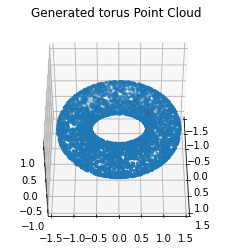

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5)
ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=50, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
ax.view_init(45, 0)
plt.show()

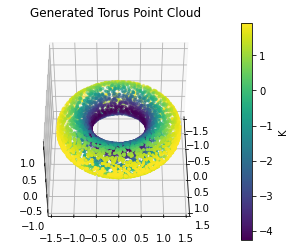

In [3]:
def generate_torus_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 

    return np.column_stack((x, y, z)), K

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000

# Generate a sphere point cloud with 1000 points and radius 1
torus, torus_K = generate_torus_cloud(num_points = num_samples, R = R, r = r)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5, c = torus_K)
# Add colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('K')
ax.set_aspect('equal')
ax.set_title("Generated Torus Point Cloud")
ax.view_init(45, 0)

In [7]:
cloud = torus
idx = 2000
query = cloud[idx].reshape(1, -1)


In [8]:
epsilon_PCA = 0.01 * 20

query = cloud[idx].reshape(1, -1)
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(cloud)
ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

pca_nbrs = cloud[ep_idx[0]]
Xi = pca_nbrs - query
Di = np.diag(np.sqrt(np.exp(-8* np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
Bi = Xi.T @ Di
    
U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
O = VT[:2, :]

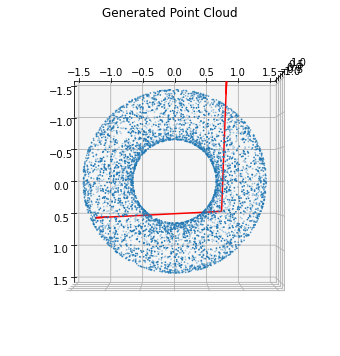

In [9]:
def plot_vector(ax, a, v, color='red', label=None):
    ax.quiver(a[0], a[1], a[2], v[0], v[1], v[2], color=color, label=label, arrow_length_ratio=0.1)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=0.5)
#ax.scatter(tau_nbrs[:, 0], tau_nbrs[:, 1], tau_nbrs[:, 2], s=3, c= 'green')
plot_vector(ax, cloud[idx], 2 * O[0])
plot_vector(ax, cloud[idx], 2 * O[1])
ax.set_title("Generated Point Cloud")
ax.view_init(90, 0)
plt.axis('equal')
plt.show()

In [30]:
def epsilon_and_tau(point_cloud, query):
    ratio_all = []
    for i in range(1, 100):
        epsilon_PCA = 0.01 * i
        nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(point_cloud)
        ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

        pca_nbrs = cloud[ep_idx[0]]
        Xi = pca_nbrs - query
        Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
        Bi = Xi.T @ Di
    
        U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
        if len(S)>= 2: 
            ratio = (S[0]+ S[1])/sum(S)
        else:
            ratio = 1.0
        ratio_all.append(ratio)
    tau = 0.01 * np.argmin(np.array(ratio_all) - min(ratio_all))
    eps_PCA = 0.01 * np.argmin(np.abs(np.array(ratio_all) - 0.9))
    return eps_PCA, tau


## For epsilon_PCA

In [98]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs, O 




def compute_Gaussian_curvature(point_cloud, query_point, extrin_dim = 3, 
                               epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur
 


In [ ]:
num_eval = int(len(torus)/20)
rmse = []
for k in tqdm(range(10, 210)):
    eps_pca = 0.01 * k
    
    curvature = []
    for i in range(num_eval):
        b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                       epsilon_PCA = eps_pca, tau_radius = 1, max_min_num = 300)
        curvature.append(b)
    v = np.array(curvature).T
    error = mean_squared_error(torus_K[:250], v, squared=False)
    rmse.append(error)
    

 80%|████████  | 160/200 [06:27<03:10,  4.76s/it]

In [ ]:
t = np.linspace(0.1, 2.1, num = 200)
plt.plot(t, np.array(rmse), c = 'blue')
#plt.plot(t, ratio_all[10: 210])
plt.ylabel('RMSE')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("RMSE for Increasing Radii of $\epsilon$-neighborhood")
plt.savefig('PCA_accuracy_tau_1.png', dpi=300)
plt.show()

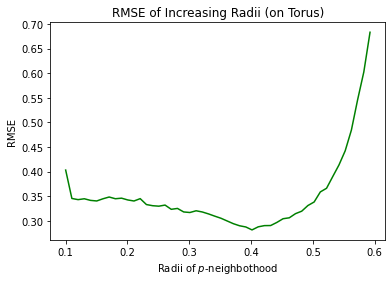

In [63]:
t = np.linspace(0.1, 2.1, num = 200)
plt.plot(t[:50], np.array(rmse)[:50], c = 'green')
#plt.plot(t, ratio_all[10: 210])
plt.ylabel('RMSE')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("RMSE of Increasing Radii (on Torus)")
#plt.savefig('PCA_accuracy_tau_1.png', dpi=300)
plt.show()

## For tau

In [93]:
def find_basis_vary_tau(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.2, tau = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])
    
    #epsilon_PCA, tau = epsilon_and_tau(point_cloud, x)


    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
       
    
    #tau_dist, tau_idx = nbrs.kneighbors(x, k, return_distance=True)
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs[1:], tau_dist[0][1:], O

def compute_Gaussian_curvature_vary_tau(point_cloud, query_point, extrin_dim = 3, epsilon_PCA = 0.1, 
                                        tau = 0.4, use_cross = True):
    
    tau_nbrs, tau_dist, O = find_basis_vary_tau(point_cloud, query_point, extrin_dim = extrin_dim, 
                                                epsilon_PCA = epsilon_PCA, tau = tau)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    max_min_num = int(0.25 * len(tau_nbrs))
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    max_cur = tensor_all[max_indices]
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    min_cur = tensor_all[min_indices]
    
    max_cur_weight = np.sqrt(np.exp(-np.array(tau_dist[max_indices]) ** 2 / epsilon_PCA))
    min_cur_weight = np.sqrt(np.exp(-np.array(tau_dist[min_indices]) ** 2 / epsilon_PCA))
    
    principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
    principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
    #principal_cur1 = sum(max_cur)/len(max_cur)
    #principal_cur2 = sum(min_cur)/len(min_cur)
    
    return principal_cur1 * principal_cur2
 


In [94]:
num_eval = int(len(torus)/20)
rmse = []
for k in tqdm(range(20, 210)):
    tau = 0.01 * k
    
    curvature = []
    for i in range(num_eval):
        b = compute_Gaussian_curvature_vary_tau(torus, torus[i].reshape(1, -1), 
                                                epsilon_PCA = 0.4, tau = tau)
        curvature.append(b)
    v = np.array(curvature).T
    error = mean_squared_error(torus_K[:250], v, squared=False)
    rmse.append(error)
    

100%|██████████| 190/190 [03:13<00:00,  1.02s/it]


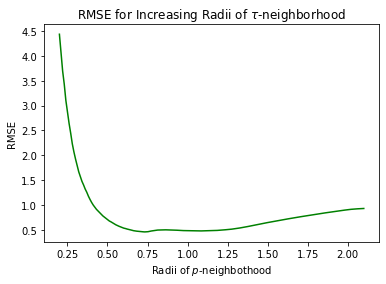

In [96]:
t = np.linspace(0.2, 2.1, num = 190)
plt.plot(t, np.array(rmse), c = 'green')
#plt.plot(t, ratio_all[10: 210])
plt.ylabel('RMSE')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("RMSE for Increasing Radii of $\\tau$-neighborhood")
plt.savefig('tau_accuracy_PCA_04.png', dpi=300)
plt.show()

In [66]:
num_eval = int(len(torus)/20)
rmse = []
for k in tqdm(range(10, 210)):
    tau = 0.01 * k
    
    curvature = []
    for i in range(num_eval):
        b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                       epsilon_PCA = 0.4, tau_radius = tau)
        curvature.append(b)
    v = np.array(curvature).T
    error = mean_squared_error(torus_K[:250], v, squared=False)
    rmse.append(error)
    

100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


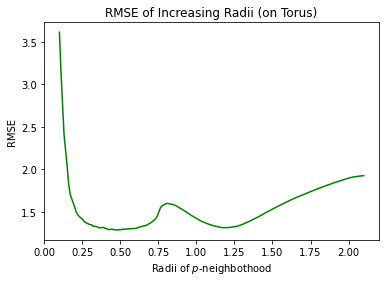

In [69]:
t = np.linspace(0.1, 2.1, num = 200)
plt.plot(t, np.array(rmse), c = 'green')
#plt.plot(t, ratio_all[10: 210])
plt.ylabel('RMSE')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("RMSE of Increasing Radii (on Torus)")
#plt.savefig('PCA_accuracy_tau_1.png', dpi=300)
plt.show()

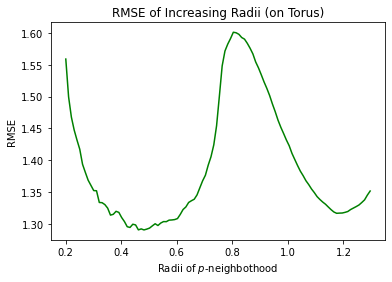

In [68]:
t = np.linspace(0.1, 2.1, num = 200)
plt.plot(t[10: 120], np.array(rmse)[10: 120], c = 'green')
#plt.plot(t, ratio_all[10: 210])
plt.ylabel('RMSE')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("RMSE of Increasing Radii (on Torus)")
#plt.savefig('PCA_accuracy_tau_1.png', dpi=300)
plt.show()

In [30]:
ratio_all = []
for i in range(1, 300):
    epsilon_PCA = 0.01 * i
    nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

    pca_nbrs = cloud[ep_idx[0]]
    Xi = pca_nbrs - query
    Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
    if len(S)>= 2: 
        ratio = (S[0]+ S[1])/sum(S)
    else:
        ratio = 1.0
    ratio_all.append(ratio)

In [31]:
np.argmin(np.abs(np.array(ratio_all) - 0.9))

23

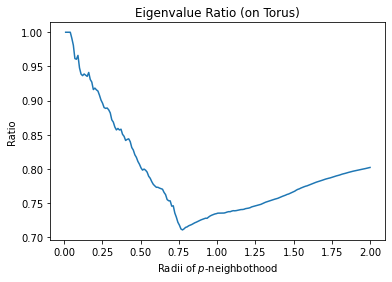

In [62]:
t = np.linspace(0.01, 2, num = 199)
plt.plot(t, ratio_all[:199])
plt.ylabel('Ratio')
plt.xlabel("Radii of $p$-neighbothood")
plt.title("Eigenvalue Ratio (on Torus)")
plt.savefig('eigen_ratio_radius.png', dpi=300)
plt.show()

In [14]:
S

array([53.38146583, 33.30870705, 14.87208848])

In [45]:
def find_basis(point_cloud, x,  extrin_dim = 3):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])
    
    epsilon_PCA, tau = epsilon_and_tau(point_cloud, x)


    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
       
    
    #tau_dist, tau_idx = nbrs.kneighbors(x, k, return_distance=True)
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs[1:], tau_dist[0][1:], epsilon_PCA, O
   
    
        
    

#this is the new one for tau automatically tuned
def compute_Gaussian_curvature(point_cloud, query_point, extrin_dim = 3, use_cross = True):
    
    tau_nbrs, tau_dist, epsilon_PCA, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim)
 
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
    max_min_num = int(0.3 * len(tau_nbrs))
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    max_cur = tensor_all[max_indices]
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    min_cur = tensor_all[min_indices]
    
    #max_cur_weight = np.sqrt(np.exp(-2* np.array(tau_dist[max_indices]) ** 2 / (2 * epsilon_PCA)))
    #min_cur_weight = np.sqrt(np.exp(-2* np.array(tau_dist[min_indices]) ** 2 / (2 * epsilon_PCA)))
    
    #principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
    #principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
    principal_cur1 = sum(max_cur)/len(max_cur)
    principal_cur2 = sum(min_cur)/len(min_cur)
    
    return principal_cur1 * principal_cur2
 

In [32]:
tau_nbrs, tau_dist, ep_pca, O = find_basis(cloud, query, extrin_dim = 3)
O2 = np.cross(O[0], O[1])

ti = tau_nbrs[1:] - tau_nbrs[0]
norms = np.square(ti).sum(axis=1)
tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

In [22]:
tau_nbrs.shape[0] * 0.35

306.25

In [19]:
def compute_mean_curvature(point_cloud, query_point, center, extrin_dim = 3,
                           epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]
        
    if np.dot(query_point[0] - center, O2) < 0:
        O2 = -O2
    

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return (max_cur + min_cur)/2
 

## Gaussian curvature 

In [ ]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1))
    curvature.append(b)

  7%|▋         | 363/5000 [04:04<1:03:10,  1.22it/s]

In [ ]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Gaussian curvature, ep_PCA = 0.2, tau is chosen according to the eigenvalue ratio plot")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [13]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                   epsilon_PCA =0.2, tau_radius = 1, max_min_num = 300)
    curvature.append(b)

100%|██████████| 5000/5000 [00:23<00:00, 214.86it/s]


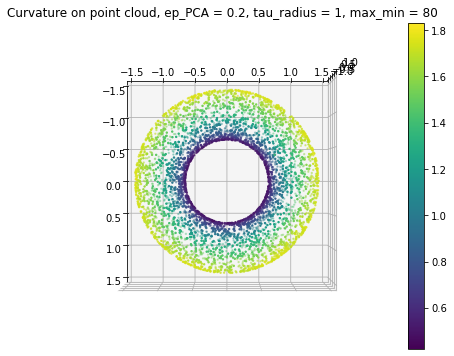

In [66]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = -v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 80")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

# On different dataset

In [30]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

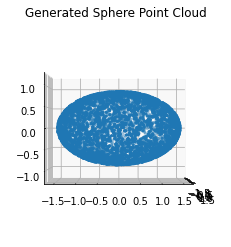

In [31]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

## Gaussian curvature

In [39]:
#old code
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 250)
    curvature.append(b)

100%|██████████| 5000/5000 [00:11<00:00, 421.22it/s]


In [55]:
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                    epsilon_PCA =0.2)
    curvature.append(b)

100%|██████████| 5000/5000 [00:13<00:00, 382.65it/s]


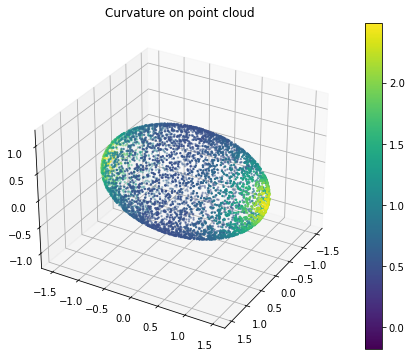

In [56]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(30, 30)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [57]:
def ellipsoid_ground_truth(point_cloud, a, b, c):
    #point_cloud: N by 3 array
    cur = []
    for p in point_cloud:
        k = 1 / (a **2 * b**2 * c**2 * (p[0]**2 / a**4 + p[1]**2 / b**4 + p[2]**2 / c**4) **2)
        cur.append(k)
    return cur

In [58]:
dd= np.array(ellipsoid_ground_truth(ellipsoid, 0.9, 1.5, 0.9))

In [59]:
from scipy.stats import pearsonr
corr, _ = pearsonr(dd, v)
corr

0.9811735828516694

## Mean curvature

In [41]:
ellipsoid_center = np.array([0, 0, 0])

num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), ellipsoid_center,
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 200)
    curvature.append(b)

100%|██████████| 5000/5000 [00:11<00:00, 417.47it/s]


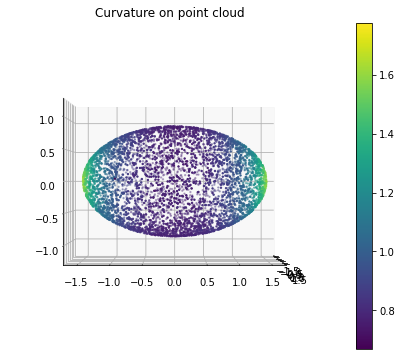

In [42]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [48]:
data = np.array([1, 2, 4, 6, 2, 1, 3, 5, 7, 4])

# Find the indices of the largest 4 numbers
indices_of_largest_4 = np.argpartition(data, -5)[-5:]

# Sort the indices based on the corresponding values
sorted_indices = indices_of_largest_4[np.argsort(data[indices_of_largest_4])]


In [49]:
indices_of_largest_4

array([9, 2, 7, 8, 3])

In [50]:
data[indices_of_largest_4]

array([4, 4, 5, 7, 6])